In [1]:
import numpy as np
import pandas as pd
import datetime
import os

from DP_LSTM import *
from keras.models import load_model
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from Plot_Self_Correlation import plot_auto_corr

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def walkfiles(rootdir): # 返回file路径的list
    flist = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    pathContainer = []
    filenameContainer = []
    for i in range(0,len(flist)):
        path = os.path.join(rootdir,flist[i])
        if os.path.isfile(path):
            pathContainer.append(path)
            filenameContainer.append(flist[i])
    return pathContainer,filenameContainer

rootdir = r'D:\WORK__wells\GraduateProgram\Data\TimeSeries'
pathContainer,filenameContainer = walkfiles(rootdir)

In [3]:
pathContainer

['D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\AUDUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\EURUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\GBPUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDCAD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDCHF.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDJPY.csv']

In [21]:
#首先对一种货币进行短期预测实验
# 第i个文件
i = 2
ExgRate_pd = pd.read_csv(pathContainer[i])
# ExgRate_pd['DateTime'] = pd.to_datetime(ExgRate_pd.DateTime)
# ExgRate_pd['ExgRate'] = ExgRate_pd.ExgRate
ExgRate_pd = ExgRate_pd.loc[(ExgRate_pd.DateTime > '2017') &(ExgRate_pd.DateTime < '2017-04-01')]
ExgRate_pd.index = [i for i in range(ExgRate_pd.shape[0])]
# ExgRate_pd = ExgRate_pd.iloc[:100000,:]

In [23]:
# 总体上查看一下汇率数据
def DrawExgRate(ExgRate_pd):
#     x = ExgRate_pd['DateTime']
    x = [i for i in range(ExgRate_pd.shape[0])]
    plt.figure(figsize=(10,6), dpi=80)
    plt.subplot(1,1,1)
    plt.plot(x,ExgRate_pd['ExgRate'],color='b',label='USDAUD Exchange Rate')
    # plt.plot(x,plot_pd['TrnsferPredict'],color='g',label='Transfer LSTM')
    plt.xlabel(r'Time Point')
    plt.ylabel(r'ExgRate')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.savefig(r'D:\WORK__wells\GraduateProgram\Pics\USDAUD汇率.jpg')
    plt.show()
    return 

In [24]:
# DrawExgRate(ExgRate_pd)
ExgRate_pd.ExgRate.describe()

count    92914.000000
mean         1.238511
std          0.014536
min          1.199320
25%          1.226900
50%          1.242580
75%          1.249510
max          1.270400
Name: ExgRate, dtype: float64

In [11]:
'''数据处理模块'''
#对实验数据进行归一化处理
def GetTimeScale(data_pd, timescale):#根据给定的时间宽度构造数据
    return_pd = data_pd.loc[data_pd.index % timescale == 0]
    return_pd.index = [i for i in range(return_pd.shape[0])]
    return return_pd

def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    Raw_pd_empty = Raw_pd.loc[Raw_pd.ExgRate.isna()]
    Raw_pd_Nonempty = Raw_pd.drop(Raw_pd_empty.index,axis=0)
    MMScaler = MinMaxScaler(feature_range=(0.1,1))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd_Nonempty['ExgRate'].get_values(),(Raw_pd_Nonempty.ExgRate.shape[0],1)))
    Raw_pd_Nonempty['ExgRate'] = MMScaled_Data
    Raw_pd = pd.concat([Raw_pd_Nonempty, Raw_pd_empty])
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length):
        result.append(Normalized_pd.ExgRate[index: index + sequence_length])
    result = np.array(result)
    return result

In [12]:
# 短期预测
'''
输入：DataFrame， 参数params
输出： 与BP神经网络、支持向量回归和时间序列模型进行比较得到的各项指标与预测的值DateFrame
'''
def ShortTimePredict(ExgRate_pd, params):
    #直观展示图
    DrawExgRate(ExgRate_pd)
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    line_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    # 对数据进行预处理
    scaleddata_pd = GetTimeScale(ExgRate_pd, params['Timescale'])
    
    Raw_pd,MMScaler = Raw_Data_Normalized(scaleddata_pd)
    print(r'处理数据:',Raw_pd.shape)
    # 构造时间序列数据
    TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
    # 划分训练测试集
    TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
    print(r'训练数据:',TrainSeries.shape)
    TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
    print(r'验证数据:',TestSeries.shape)
    TrainSeries_X = TrainSeries[:,:-1]
    TrainSeries_Y = TrainSeries[:,-1]
    TestSeries_X = TestSeries[:,:-1]
    TestSeries_Y = TestSeries[:,-1]
    # 张量化
    Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
    Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
    Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
    Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
    print(r'LSTM预测')
    LSTM_Model = build_LSTM_Model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_model = model_fit(LSTM_Model,Train_X, Train_Y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'])
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
    line_pd['RMSE'] = [RMSE]
    line_pd['MAE'] = [MAE]
    line_pd['MAPE'] = [MAPE]
    line_pd['TimeLags'] = [params['TimeLag']]
    
    
    print(r'BP 神经网络预测')
    BP_Model = build_BP_Model(inputDim = TrainSeries_X.shape[1],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_model2 = model_fit(BP_Model,TrainSeries_X, TrainSeries_Y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'])
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model2,TestSeries_X,TestSeries_Y,MMScaler)
    line_pd['RMSE_BP'] = [RMSE]
    line_pd['MAE_BP'] = [MAE]
    line_pd['MAPE_BP'] = [MAPE]
    
    print(r'支持向量回归预测')
    from sklearn.svm import SVR
    clf = SVR(C=10.0, epsilon=0.05)
    clf.fit(TrainSeries_X, TrainSeries_Y)
    Predict_y = clf.predict(TestSeries_X)
    Predict_y = MMScaler.inverse_transform(Predict_y.reshape(Predict_y.shape[0],1))
    TestSeries_Y = MMScaler.inverse_transform(TestSeries_Y.reshape(TestSeries_Y.shape[0],1))
    RMSE = evaluation_RMSE(TestSeries_Y, Predict_y)
    MAE = evaluation_MAE(TestSeries_Y, Predict_y)
    MAPE = evaluation_MAPE(TestSeries_Y, Predict_y)
    line_pd['RMSE_SVR'] = [RMSE]
    line_pd['MAE_SVR'] = [MAE]
    line_pd['MAPE_SVR'] = [MAPE]
    plt.plot(TestSeries_Y, 'b', label='True')
    plt.plot(Predict_y, 'r', label='Predict')
    plt.title('predict')
#     plt.xlabel('Hours')
    plt.ylabel('Exchange Rate')
    # plt.title(title+str(nowTime_))
#     plt.xlabel(kwargs)
    # plt.ylabel('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(RMSE,MAE,MAPE))
    plt.legend(shadow=True)
#     saveFig = r'D:\WORK__wells\PROGRAM_3\Model pic\Predict.png'
    plt.show()
    print('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(RMSE,MAE,MAPE))
    
    result_pd = pd.concat([result_pd, line_pd])
    result_pd.to_csv(r'D:\WORK__wells\GraduateProgram\Result\直接预测结果.csv',index=None)
    return TimeSeries

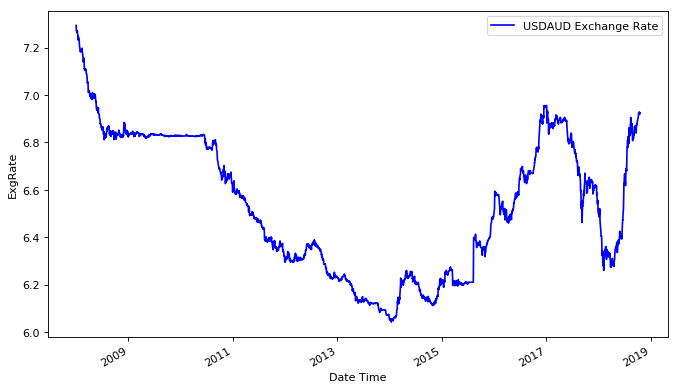

处理数据: (2625, 7)
训练数据: (1830, 11)
验证数据: (784, 11)
LSTM预测
Train on 1281 samples, validate on 549 samples
Epoch 1/1000
1281/1281 [==============================] - 5s 4ms/step - loss: 0.3095 - mean_absolute_error: 0.5232 - mean_absolute_percentage_error: 99.2957 - val_loss: 0.0347 - val_mean_absolute_error: 0.1818 - val_mean_absolute_percentage_error: 96.9861
Epoch 2/1000
1281/1281 [==============================] - 0s 198us/step - loss: 0.3039 - mean_absolute_error: 0.5178 - mean_absolute_percentage_error: 98.0865 - val_loss: 0.0328 - val_mean_absolute_error: 0.1763 - val_mean_absolute_percentage_error: 93.8878
Epoch 3/1000
1281/1281 [==============================] - 0s 196us/step - loss: 0.2980 - mean_absolute_error: 0.5120 - mean_absolute_percentage_error: 96.7728 - val_loss: 0.0307 - val_mean_absolute_error: 0.1703 - val_mean_absolute_percentage_error: 90.4817
Epoch 4/1000
1281/1281 [==============================] - 0s 198us/step - loss: 0.2914 - mean_absolute_error: 0.5055 - mean_a

Epoch 64/1000
1281/1281 [==============================] - 0s 165us/step - loss: 0.0013 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 7.4779 - val_loss: 0.0076 - val_mean_absolute_error: 0.0848 - val_mean_absolute_percentage_error: 50.5995
Epoch 65/1000
1281/1281 [==============================] - 0s 151us/step - loss: 0.0013 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 7.4081 - val_loss: 0.0075 - val_mean_absolute_error: 0.0841 - val_mean_absolute_percentage_error: 50.1780
Epoch 66/1000
1281/1281 [==============================] - 0s 168us/step - loss: 0.0012 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 7.3416 - val_loss: 0.0074 - val_mean_absolute_error: 0.0834 - val_mean_absolute_percentage_error: 49.7725
Epoch 67/1000
1281/1281 [==============================] - 0s 151us/step - loss: 0.0012 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 7.2786 - val_loss: 0.0073 - val_mean_absolute_error: 0.0827 - val_mean_abs

Epoch 96/1000
1281/1281 [==============================] - 0s 155us/step - loss: 0.0011 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 6.2111 - val_loss: 0.0054 - val_mean_absolute_error: 0.0706 - val_mean_absolute_percentage_error: 42.4981
Epoch 97/1000
1281/1281 [==============================] - 0s 155us/step - loss: 0.0011 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 6.1882 - val_loss: 0.0054 - val_mean_absolute_error: 0.0704 - val_mean_absolute_percentage_error: 42.3486
Epoch 98/1000
1281/1281 [==============================] - 0s 175us/step - loss: 0.0011 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 6.1657 - val_loss: 0.0053 - val_mean_absolute_error: 0.0701 - val_mean_absolute_percentage_error: 42.2022
Epoch 99/1000
1281/1281 [==============================] - 0s 173us/step - loss: 0.0011 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 6.1435 - val_loss: 0.0053 - val_mean_absolute_error: 0.0699 - val_mean_abs

1281/1281 [==============================] - 0s 175us/step - loss: 8.4420e-04 - mean_absolute_error: 0.0228 - mean_absolute_percentage_error: 5.2079 - val_loss: 0.0039 - val_mean_absolute_error: 0.0594 - val_mean_absolute_percentage_error: 35.9297
Epoch 159/1000
1281/1281 [==============================] - 0s 169us/step - loss: 8.4070e-04 - mean_absolute_error: 0.0227 - mean_absolute_percentage_error: 5.1949 - val_loss: 0.0039 - val_mean_absolute_error: 0.0592 - val_mean_absolute_percentage_error: 35.8429
Epoch 160/1000
1281/1281 [==============================] - 0s 182us/step - loss: 8.3721e-04 - mean_absolute_error: 0.0227 - mean_absolute_percentage_error: 5.1819 - val_loss: 0.0039 - val_mean_absolute_error: 0.0591 - val_mean_absolute_percentage_error: 35.7563
Epoch 161/1000
1281/1281 [==============================] - 0s 165us/step - loss: 8.3373e-04 - mean_absolute_error: 0.0226 - mean_absolute_percentage_error: 5.1690 - val_loss: 0.0038 - val_mean_absolute_error: 0.0589 - val_mea

1281/1281 [==============================] - 0s 173us/step - loss: 6.4653e-04 - mean_absolute_error: 0.0198 - mean_absolute_percentage_error: 4.4679 - val_loss: 0.0029 - val_mean_absolute_error: 0.0508 - val_mean_absolute_percentage_error: 30.8758
Epoch 221/1000
1281/1281 [==============================] - 0s 176us/step - loss: 6.4365e-04 - mean_absolute_error: 0.0197 - mean_absolute_percentage_error: 4.4570 - val_loss: 0.0029 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 30.7985
Epoch 222/1000
1281/1281 [==============================] - 0s 172us/step - loss: 6.4077e-04 - mean_absolute_error: 0.0197 - mean_absolute_percentage_error: 4.4461 - val_loss: 0.0029 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 30.7213
Epoch 223/1000
1281/1281 [==============================] - 0s 155us/step - loss: 6.3791e-04 - mean_absolute_error: 0.0197 - mean_absolute_percentage_error: 4.4352 - val_loss: 0.0029 - val_mean_absolute_error: 0.0504 - val_mea

1281/1281 [==============================] - 0s 192us/step - loss: 4.8420e-04 - mean_absolute_error: 0.0171 - mean_absolute_percentage_error: 3.8294 - val_loss: 0.0021 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 26.2487
Epoch 283/1000
1281/1281 [==============================] - 0s 233us/step - loss: 4.8184e-04 - mean_absolute_error: 0.0171 - mean_absolute_percentage_error: 3.8197 - val_loss: 0.0021 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 26.1767
Epoch 284/1000
1281/1281 [==============================] - 0s 209us/step - loss: 4.7950e-04 - mean_absolute_error: 0.0170 - mean_absolute_percentage_error: 3.8100 - val_loss: 0.0021 - val_mean_absolute_error: 0.0427 - val_mean_absolute_percentage_error: 26.1047
Epoch 285/1000
1281/1281 [==============================] - 0s 200us/step - loss: 4.7716e-04 - mean_absolute_error: 0.0170 - mean_absolute_percentage_error: 3.8004 - val_loss: 0.0021 - val_mean_absolute_error: 0.0426 - val_mea

1281/1281 [==============================] - 0s 183us/step - loss: 3.5314e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 3.2630 - val_loss: 0.0015 - val_mean_absolute_error: 0.0357 - val_mean_absolute_percentage_error: 21.8991
Epoch 345/1000
1281/1281 [==============================] - 0s 205us/step - loss: 3.5127e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 3.2544 - val_loss: 0.0015 - val_mean_absolute_error: 0.0355 - val_mean_absolute_percentage_error: 21.8307
Epoch 346/1000
1281/1281 [==============================] - 0s 212us/step - loss: 3.4940e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 3.2458 - val_loss: 0.0015 - val_mean_absolute_error: 0.0354 - val_mean_absolute_percentage_error: 21.7625
Epoch 347/1000
1281/1281 [==============================] - 0s 211us/step - loss: 3.4755e-04 - mean_absolute_error: 0.0145 - mean_absolute_percentage_error: 3.2372 - val_loss: 0.0015 - val_mean_absolute_error: 0.0353 - val_mea

1281/1281 [==============================] - 0s 192us/step - loss: 2.5086e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 2.7554 - val_loss: 0.0010 - val_mean_absolute_error: 0.0288 - val_mean_absolute_percentage_error: 17.8116
Epoch 407/1000
1281/1281 [==============================] - 0s 183us/step - loss: 2.4943e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 2.7478 - val_loss: 0.0010 - val_mean_absolute_error: 0.0287 - val_mean_absolute_percentage_error: 17.7484
Epoch 408/1000
1281/1281 [==============================] - 0s 163us/step - loss: 2.4801e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 2.7402 - val_loss: 9.9446e-04 - val_mean_absolute_error: 0.0286 - val_mean_absolute_percentage_error: 17.6853
Epoch 409/1000
1281/1281 [==============================] - 0s 159us/step - loss: 2.4660e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 2.7326 - val_loss: 9.8774e-04 - val_mean_absolute_error: 0.0285 -

Epoch 437/1000
1281/1281 [==============================] - 0s 176us/step - loss: 2.0988e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 2.5268 - val_loss: 8.1193e-04 - val_mean_absolute_error: 0.0257 - val_mean_absolute_percentage_error: 15.8945
Epoch 438/1000
1281/1281 [==============================] - 0s 178us/step - loss: 2.0867e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 2.5197 - val_loss: 8.0609e-04 - val_mean_absolute_error: 0.0256 - val_mean_absolute_percentage_error: 15.8344
Epoch 439/1000
1281/1281 [==============================] - 0s 193us/step - loss: 2.0746e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 2.5126 - val_loss: 8.0028e-04 - val_mean_absolute_error: 0.0255 - val_mean_absolute_percentage_error: 15.7744
Epoch 440/1000
1281/1281 [==============================] - 0s 185us/step - loss: 2.0626e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 2.5056 - val_loss: 7.9450e-04 - val_mean_a

Epoch 468/1000
1281/1281 [==============================] - 0s 165us/step - loss: 1.7536e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 2.3155 - val_loss: 6.4463e-04 - val_mean_absolute_error: 0.0227 - val_mean_absolute_percentage_error: 14.0791
Epoch 469/1000
1281/1281 [==============================] - 0s 155us/step - loss: 1.7435e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 2.3090 - val_loss: 6.3969e-04 - val_mean_absolute_error: 0.0227 - val_mean_absolute_percentage_error: 14.0225
Epoch 470/1000
1281/1281 [==============================] - 0s 167us/step - loss: 1.7334e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 2.3025 - val_loss: 6.3479e-04 - val_mean_absolute_error: 0.0226 - val_mean_absolute_percentage_error: 13.9660
Epoch 471/1000
1281/1281 [==============================] - 0s 180us/step - loss: 1.7235e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 2.2960 - val_loss: 6.2991e-04 - val_mean_a

Epoch 499/1000
1281/1281 [==============================] - 0s 201us/step - loss: 1.4699e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 2.1212 - val_loss: 5.0478e-04 - val_mean_absolute_error: 0.0200 - val_mean_absolute_percentage_error: 12.3724
Epoch 500/1000
1281/1281 [==============================] - 0s 203us/step - loss: 1.4618e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 2.1152 - val_loss: 5.0071e-04 - val_mean_absolute_error: 0.0199 - val_mean_absolute_percentage_error: 12.3193
Epoch 501/1000
1281/1281 [==============================] - 0s 198us/step - loss: 1.4537e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 2.1093 - val_loss: 4.9666e-04 - val_mean_absolute_error: 0.0198 - val_mean_absolute_percentage_error: 12.2665
Epoch 502/1000
1281/1281 [==============================] - 0s 166us/step - loss: 1.4456e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 2.1034 - val_loss: 4.9265e-04 - val_mean_a

Epoch 530/1000
1281/1281 [==============================] - 0s 158us/step - loss: 1.2444e-04 - mean_absolute_error: 0.0088 - mean_absolute_percentage_error: 1.9461 - val_loss: 3.9095e-04 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 10.8004
Epoch 531/1000
1281/1281 [==============================] - 0s 184us/step - loss: 1.2381e-04 - mean_absolute_error: 0.0088 - mean_absolute_percentage_error: 1.9408 - val_loss: 3.8769e-04 - val_mean_absolute_error: 0.0174 - val_mean_absolute_percentage_error: 10.7517
Epoch 532/1000
1281/1281 [==============================] - 0s 166us/step - loss: 1.2318e-04 - mean_absolute_error: 0.0088 - mean_absolute_percentage_error: 1.9355 - val_loss: 3.8446e-04 - val_mean_absolute_error: 0.0173 - val_mean_absolute_percentage_error: 10.7031
Epoch 533/1000
1281/1281 [==============================] - 0s 198us/step - loss: 1.2255e-04 - mean_absolute_error: 0.0087 - mean_absolute_percentage_error: 1.9302 - val_loss: 3.8125e-04 - val_mean_a

Epoch 561/1000
1281/1281 [==============================] - 0s 190us/step - loss: 1.0725e-04 - mean_absolute_error: 0.0081 - mean_absolute_percentage_error: 1.7924 - val_loss: 3.0140e-04 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 9.3750
Epoch 562/1000
1281/1281 [==============================] - 0s 230us/step - loss: 1.0677e-04 - mean_absolute_error: 0.0081 - mean_absolute_percentage_error: 1.7878 - val_loss: 2.9889e-04 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 9.3316
Epoch 563/1000
1281/1281 [==============================] - 0s 221us/step - loss: 1.0631e-04 - mean_absolute_error: 0.0081 - mean_absolute_percentage_error: 1.7833 - val_loss: 2.9641e-04 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 9.2883
Epoch 564/1000
1281/1281 [==============================] - 0s 240us/step - loss: 1.0585e-04 - mean_absolute_error: 0.0080 - mean_absolute_percentage_error: 1.7787 - val_loss: 2.9395e-04 - val_mean_abso

Epoch 592/1000
1281/1281 [==============================] - 0s 176us/step - loss: 9.4831e-05 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 1.6636 - val_loss: 2.3392e-04 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 8.1045
Epoch 593/1000
1281/1281 [==============================] - 0s 155us/step - loss: 9.4503e-05 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 1.6599 - val_loss: 2.3209e-04 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 8.0662
Epoch 594/1000
1281/1281 [==============================] - 0s 178us/step - loss: 9.4179e-05 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 1.6563 - val_loss: 2.3027e-04 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 8.0283
Epoch 595/1000
1281/1281 [==============================] - 0s 179us/step - loss: 9.3858e-05 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 1.6527 - val_loss: 2.2847e-04 - val_mean_abso

Epoch 623/1000
1281/1281 [==============================] - 0s 208us/step - loss: 8.6491e-05 - mean_absolute_error: 0.0071 - mean_absolute_percentage_error: 1.5657 - val_loss: 1.8571e-04 - val_mean_absolute_error: 0.0115 - val_mean_absolute_percentage_error: 7.0175
Epoch 624/1000
1281/1281 [==============================] - 0s 198us/step - loss: 8.6281e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1.5630 - val_loss: 1.8444e-04 - val_mean_absolute_error: 0.0115 - val_mean_absolute_percentage_error: 6.9859
Epoch 625/1000
1281/1281 [==============================] - 0s 181us/step - loss: 8.6074e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1.5603 - val_loss: 1.8319e-04 - val_mean_absolute_error: 0.0114 - val_mean_absolute_percentage_error: 6.9546
Epoch 626/1000
1281/1281 [==============================] - 0s 174us/step - loss: 8.5871e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1.5576 - val_loss: 1.8195e-04 - val_mean_abso

Epoch 654/1000
1281/1281 [==============================] - 0s 209us/step - loss: 8.1403e-05 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1.4924 - val_loss: 1.5340e-04 - val_mean_absolute_error: 0.0102 - val_mean_absolute_percentage_error: 6.1594
Epoch 655/1000
1281/1281 [==============================] - 0s 219us/step - loss: 8.1283e-05 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1.4905 - val_loss: 1.5258e-04 - val_mean_absolute_error: 0.0102 - val_mean_absolute_percentage_error: 6.1357
Epoch 656/1000
1281/1281 [==============================] - 0s 223us/step - loss: 8.1166e-05 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1.4885 - val_loss: 1.5177e-04 - val_mean_absolute_error: 0.0101 - val_mean_absolute_percentage_error: 6.1123
Epoch 657/1000
1281/1281 [==============================] - 0s 198us/step - loss: 8.1051e-05 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1.4866 - val_loss: 1.5098e-04 - val_mean_abso

Epoch 685/1000
1281/1281 [==============================] - 0s 193us/step - loss: 7.8691e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1.4428 - val_loss: 1.3327e-04 - val_mean_absolute_error: 0.0093 - val_mean_absolute_percentage_error: 5.5380
Epoch 686/1000
1281/1281 [==============================] - 0s 171us/step - loss: 7.8633e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1.4415 - val_loss: 1.3278e-04 - val_mean_absolute_error: 0.0093 - val_mean_absolute_percentage_error: 5.5217
Epoch 687/1000
1281/1281 [==============================] - 0s 158us/step - loss: 7.8577e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1.4402 - val_loss: 1.3230e-04 - val_mean_absolute_error: 0.0092 - val_mean_absolute_percentage_error: 5.5057
Epoch 688/1000
1281/1281 [==============================] - 0s 183us/step - loss: 7.8522e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1.4390 - val_loss: 1.3183e-04 - val_mean_abso

Epoch 716/1000
1281/1281 [==============================] - 0s 164us/step - loss: 7.7526e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.4113 - val_loss: 1.2173e-04 - val_mean_absolute_error: 0.0087 - val_mean_absolute_percentage_error: 5.1346
Epoch 717/1000
1281/1281 [==============================] - 0s 172us/step - loss: 7.7506e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.4106 - val_loss: 1.2146e-04 - val_mean_absolute_error: 0.0087 - val_mean_absolute_percentage_error: 5.1246
Epoch 718/1000
1281/1281 [==============================] - 0s 182us/step - loss: 7.7487e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.4098 - val_loss: 1.2120e-04 - val_mean_absolute_error: 0.0087 - val_mean_absolute_percentage_error: 5.1148
Epoch 719/1000
1281/1281 [==============================] - 0s 178us/step - loss: 7.7469e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.4091 - val_loss: 1.2095e-04 - val_mean_abso

Epoch 747/1000
1281/1281 [==============================] - 0s 186us/step - loss: 7.7247e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.3945 - val_loss: 1.1573e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4.9047
Epoch 748/1000
1281/1281 [==============================] - 0s 161us/step - loss: 7.7247e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.3941 - val_loss: 1.1560e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4.8997
Epoch 749/1000
1281/1281 [==============================] - 0s 169us/step - loss: 7.7248e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.3937 - val_loss: 1.1548e-04 - val_mean_absolute_error: 0.0083 - val_mean_absolute_percentage_error: 4.8948
Epoch 750/1000
1281/1281 [==============================] - 0s 157us/step - loss: 7.7249e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.3934 - val_loss: 1.1536e-04 - val_mean_abso

Epoch 778/1000
1281/1281 [==============================] - 0s 172us/step - loss: 7.7421e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3862 - val_loss: 1.1306e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8013
Epoch 779/1000
1281/1281 [==============================] - 0s 184us/step - loss: 7.7432e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3861 - val_loss: 1.1301e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7995
Epoch 780/1000
1281/1281 [==============================] - 0s 173us/step - loss: 7.7442e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3859 - val_loss: 1.1296e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7979
Epoch 781/1000
1281/1281 [==============================] - 0s 175us/step - loss: 7.7453e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3857 - val_loss: 1.1292e-04 - val_mean_abso

Epoch 809/1000
1281/1281 [==============================] - 0s 158us/step - loss: 7.7800e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3835 - val_loss: 1.1229e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7809
Epoch 810/1000
1281/1281 [==============================] - 0s 173us/step - loss: 7.7813e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3835 - val_loss: 1.1229e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7811
Epoch 811/1000
1281/1281 [==============================] - 0s 163us/step - loss: 7.7826e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3835 - val_loss: 1.1229e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7814
Epoch 812/1000
1281/1281 [==============================] - 0s 191us/step - loss: 7.7839e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3835 - val_loss: 1.1228e-04 - val_mean_abso

Epoch 840/1000
1281/1281 [==============================] - 0s 183us/step - loss: 7.8158e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3849 - val_loss: 1.1250e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8040
Epoch 841/1000
1281/1281 [==============================] - 0s 155us/step - loss: 7.8167e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3850 - val_loss: 1.1252e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8051
Epoch 842/1000
1281/1281 [==============================] - 0s 156us/step - loss: 7.8175e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3850 - val_loss: 1.1253e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8061
Epoch 843/1000
1281/1281 [==============================] - 0s 161us/step - loss: 7.8183e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3851 - val_loss: 1.1254e-04 - val_mean_abso

Epoch 871/1000
1281/1281 [==============================] - 0s 159us/step - loss: 7.8271e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3867 - val_loss: 1.1281e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8317
Epoch 872/1000
1281/1281 [==============================] - 0s 188us/step - loss: 7.8270e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3867 - val_loss: 1.1281e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8324
Epoch 873/1000
1281/1281 [==============================] - 0s 158us/step - loss: 7.8268e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3867 - val_loss: 1.1282e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8331
Epoch 874/1000
1281/1281 [==============================] - 0s 166us/step - loss: 7.8266e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3867 - val_loss: 1.1282e-04 - val_mean_abso

Epoch 902/1000
1281/1281 [==============================] - 0s 175us/step - loss: 7.8077e-05 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1.3860 - val_loss: 1.1280e-04 - val_mean_absolute_error: 0.0083 - val_mean_absolute_percentage_error: 4.8463
Epoch 903/1000
1281/1281 [==============================] - 0s 156us/step - loss: 7.8065e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3858 - val_loss: 1.1278e-04 - val_mean_absolute_error: 0.0083 - val_mean_absolute_percentage_error: 4.8461
Epoch 904/1000
1281/1281 [==============================] - 0s 162us/step - loss: 7.8053e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3856 - val_loss: 1.1276e-04 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.8458
Epoch 905/1000
1281/1281 [==============================] - 0s 152us/step - loss: 7.8041e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1.3853 - val_loss: 1.1274e-04 - val_mean_abso

Epoch 933/1000
1281/1281 [==============================] - 0s 159us/step - loss: 7.8727e-05 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1.4155 - val_loss: 1.1477e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4.9438
Epoch 934/1000
1281/1281 [==============================] - 0s 190us/step - loss: 7.9097e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1.4249 - val_loss: 1.1515e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4.9601
Epoch 935/1000
1281/1281 [==============================] - 0s 169us/step - loss: 7.9584e-05 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1.4360 - val_loss: 1.1555e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4.9773
Epoch 936/1000
1281/1281 [==============================] - 0s 153us/step - loss: 8.0192e-05 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1.4483 - val_loss: 1.1597e-04 - val_mean_abso

Epoch 964/1000
1281/1281 [==============================] - 0s 148us/step - loss: 9.7359e-05 - mean_absolute_error: 0.0077 - mean_absolute_percentage_error: 1.6330 - val_loss: 1.3585e-04 - val_mean_absolute_error: 0.0096 - val_mean_absolute_percentage_error: 5.7033
Epoch 965/1000
1281/1281 [==============================] - 0s 155us/step - loss: 9.1642e-05 - mean_absolute_error: 0.0074 - mean_absolute_percentage_error: 1.5815 - val_loss: 1.3140e-04 - val_mean_absolute_error: 0.0093 - val_mean_absolute_percentage_error: 5.5581
Epoch 966/1000
1281/1281 [==============================] - 0s 156us/step - loss: 8.4179e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1.5094 - val_loss: 1.2553e-04 - val_mean_absolute_error: 0.0090 - val_mean_absolute_percentage_error: 5.3598
Epoch 967/1000
1281/1281 [==============================] - 0s 176us/step - loss: 7.8446e-05 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1.4425 - val_loss: 1.1999e-04 - val_mean_abso

Epoch 995/1000
1281/1281 [==============================] - 0s 180us/step - loss: 7.4998e-05 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1.3556 - val_loss: 1.0969e-04 - val_mean_absolute_error: 0.0081 - val_mean_absolute_percentage_error: 4.7604
Epoch 996/1000
1281/1281 [==============================] - 0s 164us/step - loss: 7.5011e-05 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1.3557 - val_loss: 1.0971e-04 - val_mean_absolute_error: 0.0081 - val_mean_absolute_percentage_error: 4.7617
Epoch 997/1000
1281/1281 [==============================] - 0s 156us/step - loss: 7.5023e-05 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1.3558 - val_loss: 1.0973e-04 - val_mean_absolute_error: 0.0081 - val_mean_absolute_percentage_error: 4.7630
Epoch 998/1000
1281/1281 [==============================] - 0s 149us/step - loss: 7.5036e-05 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1.3560 - val_loss: 1.0975e-04 - val_mean_abso

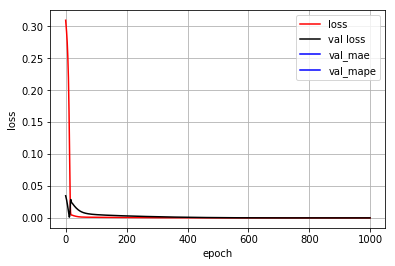

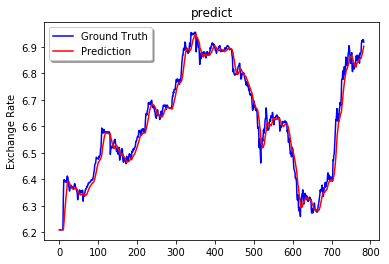

RMSE:0.03386455938108351  ,MAE:0.02409733384580024  ,MAPE:0.36491614680082846 
BP 神经网络预测
Train on 1281 samples, validate on 549 samples
Epoch 1/1000
1281/1281 [==============================] - 1s 899us/step - loss: 0.2551 - mean_absolute_error: 0.3889 - mean_absolute_percentage_error: 67.4906 - val_loss: 0.0011 - val_mean_absolute_error: 0.0301 - val_mean_absolute_percentage_error: 17.9559
Epoch 2/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0824 - mean_absolute_error: 0.2245 - mean_absolute_percentage_error: 45.3050 - val_loss: 0.0115 - val_mean_absolute_error: 0.1061 - val_mean_absolute_percentage_error: 59.2267
Epoch 3/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0737 - mean_absolute_error: 0.2054 - mean_absolute_percentage_error: 41.0723 - val_loss: 0.0051 - val_mean_absolute_error: 0.0699 - val_mean_absolute_percentage_error: 39.4495
Epoch 4/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0592 - mean

Epoch 32/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0140 - mean_absolute_error: 0.0899 - mean_absolute_percentage_error: 17.1777 - val_loss: 3.4481e-04 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 9.4219
Epoch 33/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0146 - mean_absolute_error: 0.0918 - mean_absolute_percentage_error: 17.7182 - val_loss: 3.2266e-04 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 9.0176
Epoch 34/1000
1281/1281 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 16.908 - 0s 39us/step - loss: 0.0147 - mean_absolute_error: 0.0929 - mean_absolute_percentage_error: 17.6772 - val_loss: 2.1489e-04 - val_mean_absolute_error: 0.0120 - val_mean_absolute_percentage_error: 6.8263
Epoch 35/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0145 - mean_absolute_error: 0.0898 - me

1281/1281 [==============================] - 0s 39us/step - loss: 0.0082 - mean_absolute_error: 0.0678 - mean_absolute_percentage_error: 12.6438 - val_loss: 2.0300e-04 - val_mean_absolute_error: 0.0117 - val_mean_absolute_percentage_error: 6.7453
Epoch 64/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0087 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 13.0325 - val_loss: 2.3936e-04 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 7.6177
Epoch 65/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0084 - mean_absolute_error: 0.0677 - mean_absolute_percentage_error: 12.6910 - val_loss: 2.4764e-04 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 7.7894
Epoch 66/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0077 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 11.9151 - val_loss: 2.0603e-04 - val_mean_absolute_error: 0.0118 - val_mean_abso

1281/1281 [==============================] - 0s 47us/step - loss: 0.0037 - mean_absolute_error: 0.0432 - mean_absolute_percentage_error: 7.9662 - val_loss: 1.4185e-04 - val_mean_absolute_error: 0.0088 - val_mean_absolute_percentage_error: 4.9135
Epoch 126/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0037 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.3820 - val_loss: 1.4737e-04 - val_mean_absolute_error: 0.0092 - val_mean_absolute_percentage_error: 5.1946
Epoch 127/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0035 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 7.9839 - val_loss: 1.5127e-04 - val_mean_absolute_error: 0.0094 - val_mean_absolute_percentage_error: 5.3740
Epoch 128/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0035 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 8.2093 - val_loss: 1.7121e-04 - val_mean_absolute_error: 0.0106 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0023 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 7.3281 - val_loss: 1.5337e-04 - val_mean_absolute_error: 0.0106 - val_mean_absolute_percentage_error: 6.2052
Epoch 188/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0023 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 7.3659 - val_loss: 1.7082e-04 - val_mean_absolute_error: 0.0113 - val_mean_absolute_percentage_error: 6.6273
Epoch 189/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0023 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 7.2852 - val_loss: 1.3110e-04 - val_mean_absolute_error: 0.0095 - val_mean_absolute_percentage_error: 5.5451
Epoch 190/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0021 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 7.2799 - val_loss: 1.2931e-04 - val_mean_absolute_error: 0.0094 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0020 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 7.1855 - val_loss: 9.3346e-05 - val_mean_absolute_error: 0.0082 - val_mean_absolute_percentage_error: 4.7365
Epoch 250/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0019 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 6.8675 - val_loss: 9.1845e-05 - val_mean_absolute_error: 0.0081 - val_mean_absolute_percentage_error: 4.6873
Epoch 251/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0020 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 7.2060 - val_loss: 2.3857e-04 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 8.3149
Epoch 252/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0021 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 7.2148 - val_loss: 1.6325e-04 - val_mean_absolute_error: 0.0114 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0017 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 6.7718 - val_loss: 5.5549e-05 - val_mean_absolute_error: 0.0060 - val_mean_absolute_percentage_error: 3.5624
Epoch 312/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0016 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 6.5716 - val_loss: 5.0971e-05 - val_mean_absolute_error: 0.0056 - val_mean_absolute_percentage_error: 3.3040
Epoch 313/1000
1281/1281 [==============================] - 0s 40us/step - loss: 0.0017 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 6.8921 - val_loss: 1.2269e-04 - val_mean_absolute_error: 0.0098 - val_mean_absolute_percentage_error: 5.9341
Epoch 314/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0017 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 6.7818 - val_loss: 9.6518e-05 - val_mean_absolute_error: 0.0085 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0016 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 6.5956 - val_loss: 4.6032e-05 - val_mean_absolute_error: 0.0054 - val_mean_absolute_percentage_error: 3.1649
Epoch 374/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0016 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 6.5400 - val_loss: 1.1309e-04 - val_mean_absolute_error: 0.0094 - val_mean_absolute_percentage_error: 5.6948
Epoch 375/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 6.3329 - val_loss: 4.5292e-05 - val_mean_absolute_error: 0.0053 - val_mean_absolute_percentage_error: 3.1517
Epoch 376/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 6.3938 - val_loss: 4.5420e-05 - val_mean_absolute_error: 0.0053 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 6.4840 - val_loss: 3.8152e-05 - val_mean_absolute_error: 0.0045 - val_mean_absolute_percentage_error: 2.3262
Epoch 436/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 6.4997 - val_loss: 5.9212e-05 - val_mean_absolute_error: 0.0063 - val_mean_absolute_percentage_error: 3.5035
Epoch 437/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0018 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 6.7049 - val_loss: 3.5476e-04 - val_mean_absolute_error: 0.0180 - val_mean_absolute_percentage_error: 10.4782
Epoch 438/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 6.3974 - val_loss: 2.6956e-04 - val_mean_absolute_error: 0.0153 - val_mean_abso

1281/1281 [==============================] - 0s 47us/step - loss: 0.0013 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 6.1013 - val_loss: 4.0943e-05 - val_mean_absolute_error: 0.0048 - val_mean_absolute_percentage_error: 2.7197
Epoch 498/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0013 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 6.1231 - val_loss: 4.7803e-05 - val_mean_absolute_error: 0.0055 - val_mean_absolute_percentage_error: 3.2280
Epoch 499/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 6.2869 - val_loss: 4.1197e-05 - val_mean_absolute_error: 0.0049 - val_mean_absolute_percentage_error: 2.7892
Epoch 500/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0014 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 6.3260 - val_loss: 9.1816e-05 - val_mean_absolute_error: 0.0084 - val_mean_absol

1281/1281 [==============================] - 0s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 6.2367 - val_loss: 7.5119e-05 - val_mean_absolute_error: 0.0075 - val_mean_absolute_percentage_error: 4.4547
Epoch 560/1000
1281/1281 [==============================] - 0s 39us/step - loss: 0.0012 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 5.9093 - val_loss: 4.2170e-05 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 2.7773
Epoch 561/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0014 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 6.1055 - val_loss: 1.8722e-04 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 7.4740
Epoch 562/1000
1281/1281 [==============================] - 0s 47us/step - loss: 0.0014 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 6.1905 - val_loss: 1.4931e-04 - val_mean_absolute_error: 0.0112 - val_mean_absol

1281/1281 [==============================] - 0s 48us/step - loss: 0.0013 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 5.8744 - val_loss: 7.5871e-05 - val_mean_absolute_error: 0.0075 - val_mean_absolute_percentage_error: 4.5250
Epoch 622/1000
1281/1281 [==============================] - 0s 49us/step - loss: 0.0013 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 5.8948 - val_loss: 4.2312e-05 - val_mean_absolute_error: 0.0052 - val_mean_absolute_percentage_error: 3.0780
Epoch 623/1000
1281/1281 [==============================] - 0s 52us/step - loss: 0.0013 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 6.0080 - val_loss: 3.4566e-05 - val_mean_absolute_error: 0.0042 - val_mean_absolute_percentage_error: 2.2179
Epoch 624/1000
1281/1281 [==============================] - 0s 59us/step - loss: 0.0012 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 5.7944 - val_loss: 3.8666e-05 - val_mean_absolute_error: 0.0048 - val_mean_absol

1281/1281 [==============================] - 0s 50us/step - loss: 0.0014 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 6.0574 - val_loss: 5.3810e-05 - val_mean_absolute_error: 0.0060 - val_mean_absolute_percentage_error: 3.3309
Epoch 684/1000
1281/1281 [==============================] - 0s 48us/step - loss: 0.0015 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 6.2564 - val_loss: 8.4365e-05 - val_mean_absolute_error: 0.0078 - val_mean_absolute_percentage_error: 4.1437
Epoch 685/1000
1281/1281 [==============================] - 0s 43us/step - loss: 0.0020 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 7.2595 - val_loss: 2.5652e-04 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 8.7574
Epoch 686/1000
1281/1281 [==============================] - 0s 52us/step - loss: 0.0012 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 5.6668 - val_loss: 4.9633e-05 - val_mean_absolute_error: 0.0056 - val_mean_absol

1281/1281 [==============================] - 0s 46us/step - loss: 0.0013 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 6.1113 - val_loss: 3.3711e-05 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage_error: 2.0886
Epoch 746/1000
1281/1281 [==============================] - 0s 48us/step - loss: 0.0014 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 6.1490 - val_loss: 3.6348e-04 - val_mean_absolute_error: 0.0180 - val_mean_absolute_percentage_error: 10.7363
Epoch 747/1000
1281/1281 [==============================] - 0s 46us/step - loss: 0.0014 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 6.2533 - val_loss: 4.4038e-05 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 2.6843
Epoch 748/1000
1281/1281 [==============================] - 0s 44us/step - loss: 0.0012 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 5.7832 - val_loss: 1.5556e-04 - val_mean_absolute_error: 0.0113 - val_mean_abso

1281/1281 [==============================] - 0s 45us/step - loss: 0.0011 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 5.7140 - val_loss: 4.5034e-05 - val_mean_absolute_error: 0.0054 - val_mean_absolute_percentage_error: 3.2157
Epoch 808/1000
1281/1281 [==============================] - 0s 48us/step - loss: 0.0013 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 5.7073 - val_loss: 3.7783e-05 - val_mean_absolute_error: 0.0047 - val_mean_absolute_percentage_error: 2.7229
Epoch 809/1000
1281/1281 [==============================] - 0s 45us/step - loss: 0.0012 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 5.7174 - val_loss: 4.5469e-05 - val_mean_absolute_error: 0.0054 - val_mean_absolute_percentage_error: 3.2115
Epoch 810/1000
1281/1281 [==============================] - 0s 50us/step - loss: 0.0012 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 5.7628 - val_loss: 4.1199e-05 - val_mean_absolute_error: 0.0046 - val_mean_absol

1281/1281 [==============================] - 0s 68us/step - loss: 0.0012 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 5.7798 - val_loss: 6.8847e-05 - val_mean_absolute_error: 0.0068 - val_mean_absolute_percentage_error: 3.7862
Epoch 870/1000
1281/1281 [==============================] - 0s 51us/step - loss: 0.0012 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 5.8200 - val_loss: 2.4262e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 8.6649
Epoch 871/1000
1281/1281 [==============================] - 0s 46us/step - loss: 0.0010 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 5.2966 - val_loss: 3.3962e-05 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage_error: 2.1480
Epoch 872/1000
1281/1281 [==============================] - 0s 46us/step - loss: 0.0012 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 5.6283 - val_loss: 3.2349e-05 - val_mean_absolute_error: 0.0039 - val_mean_absol

1281/1281 [==============================] - 0s 51us/step - loss: 0.0011 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 5.5159 - val_loss: 3.9772e-05 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 2.8967
Epoch 932/1000
1281/1281 [==============================] - 0s 50us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 5.5822 - val_loss: 6.8859e-05 - val_mean_absolute_error: 0.0072 - val_mean_absolute_percentage_error: 4.2858
Epoch 933/1000
1281/1281 [==============================] - 0s 48us/step - loss: 0.0011 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 5.3899 - val_loss: 2.9979e-05 - val_mean_absolute_error: 0.0037 - val_mean_absolute_percentage_error: 1.9928
Epoch 934/1000
1281/1281 [==============================] - 0s 50us/step - loss: 0.0011 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 5.4698 - val_loss: 8.1268e-05 - val_mean_absolute_error: 0.0079 - val_mean_absol

1281/1281 [==============================] - 0s 49us/step - loss: 9.8632e-04 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 5.4304 - val_loss: 3.4966e-05 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 2.5023
Epoch 994/1000
1281/1281 [==============================] - 0s 50us/step - loss: 0.0010 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 5.3756 - val_loss: 3.8673e-05 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 2.2909
Epoch 995/1000
1281/1281 [==============================] - 0s 44us/step - loss: 9.8694e-04 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 5.2633 - val_loss: 3.9237e-05 - val_mean_absolute_error: 0.0049 - val_mean_absolute_percentage_error: 2.8298
Epoch 996/1000
1281/1281 [==============================] - 0s 41us/step - loss: 9.7163e-04 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 5.2411 - val_loss: 9.1115e-05 - val_mean_absolute_error: 0.0084 - va

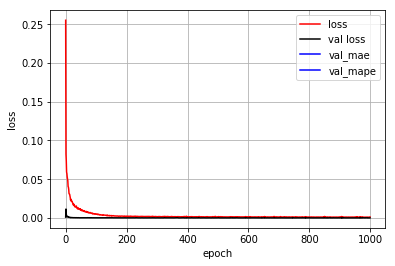

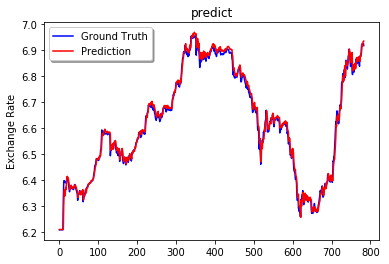

RMSE:0.01859396198543864  ,MAE:0.013369228264750276  ,MAPE:0.20200278185241802 
支持向量回归预测


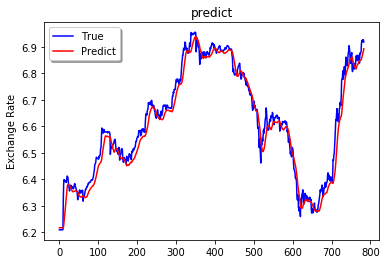

RMSE:0.03911341922624301  ,MAE:0.02932225100629617  ,MAPE:0.4438863583858609 


In [13]:
params = {
          'Timescale':1,
          'lr': 0.0001,
          'nb_hidden_cell': [80,80,80,80,80],
          'epochs': 1000,
          'batch_size': 100,
          'TimeLag': 10,
          'TrainTestSplit':0.7,
          
          'TransferEpochs':20,
          'TransferBatch_size':500,
          'frozenlayer':3}
data_pd = ShortTimePredict(ExgRate_pd.iloc[:,:], params)